Newton solution:
[2.75098732e-01 1.94363867e-01 0.00000000e+00 1.26011677e-01
 2.19314541e-01 2.68023437e-01 2.14958618e-01 4.19806825e-01
 3.61932192e-01 9.57536511e-02 3.09429003e-01 4.68968893e-01
 5.50921270e-01 4.56685835e-01 4.76786161e-01 4.58119875e-01
 2.23619317e-01 4.84698126e-01 6.68207490e-01 7.56055016e-01
 6.22619965e-01 5.11824990e-01 5.90226930e-01 4.63965018e-01
 4.15901576e-01 4.17189565e-01 5.51104298e-01 7.10164179e-01
 8.49718588e-01 9.11812229e-01 7.37788484e-01 5.28863878e-01
 6.56376131e-01 6.77894606e-01 6.74269488e-01 6.84126248e-01
 7.51186769e-01 8.55373178e-01 9.60544034e-01 9.99999171e-01
 7.99556150e-01 5.28864410e-01 6.56377388e-01 6.77895500e-01
 6.74270035e-01 6.84126628e-01 7.51187161e-01 8.55373705e-01
 9.60544746e-01 1.00000000e+00 7.99556832e-01 5.11827015e-01
 5.90231962e-01 4.63967290e-01 4.15902703e-01 4.17190298e-01
 5.51105187e-01 7.10165527e-01 8.49720498e-01 9.11814488e-01
 7.37790353e-01 4.76791197e-01 4.58134559e-01 2.23620094e-01
 4.8469

<Axes: >

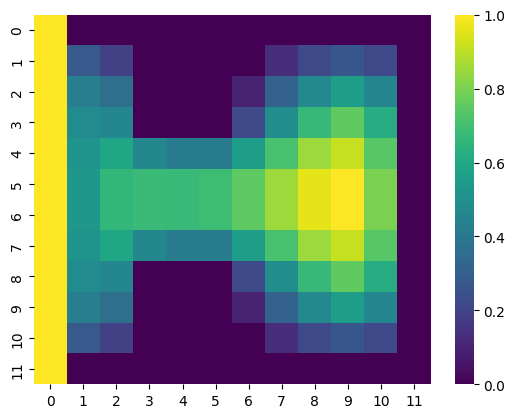

In [22]:
import numpy as np
import seaborn as sns

def generate_grid(i_max, j_max, beam_pos, beam_h, beam_w, left_speed=1, top_speed=1):
    '''
    Genera la malla con medidas ixj, y genera tambien las vigas en la posicion y con el tamaño indicado
    '''
    # Grid
    grid = np.zeros((i_max, j_max))

    # Boundary conditions
    for i in range(i_max):
        grid[i,0]=left_speed
    # for j in range(j_max):
    #     grid[0,j]=top_speed

    # Bottom beam
    for i in range(beam_w):
        for j in range(beam_h):
            grid[i_max-beam_h+j, i+beam_pos] = -1

   # top beam es el otro lado de la viga
    for i in range(beam_w):
        for j in range(beam_h):
            grid[j, i+beam_pos] = -1

    return grid

# Se considera frontera los bordes de la malla y los bordes de las vigas
def is_border(grid, i, j):
    '''
    Retorna True si la posicion dada en la malla, es una condicion de frontera
    '''
    grid_h = grid.shape[0]
    grid_w = grid.shape[1]

    if (i >= (grid_h-1)) or (j >= (grid_w-1)) or (i <= 0) or (j <= 0):
        return True
    elif (grid[i+1,j] == -1) or (grid[i-1,j] == -1) or (grid[i,j-1] == -1) or (grid[i,j+1] == -1):
        return True
    elif (grid[i+1,j+1] == -1) or (grid[i-1,j+1] == -1) or (grid[i+1,j-1] == -1) or (grid[i-1,j-1] == -1):
        return True
    else:
        return False


def count_values(grid):
    '''
    Cuenta la cantidad de valores de una malla que no son condiciones de frontera
    '''
    counter = 0
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not is_border(grid, i, j):
                counter += 1
    return counter


def numerate_variables(grid):
    '''
    Crea un diccionario con códigos correspondientes a las posiciones de cada cuadro y su respectivo número de variable
    '''
    counter = 0
    variables = {}
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not is_border(grid, i, j):
                key = str(i) + "_" + str(j)
                variables[key] = counter
                counter +=1
    return variables


def get_key(i,j):
    '''
    Para una posición dada i,j retorna la llave para acceder a su valor numérico en un diccionario
    '''
    return str(i) + "_" + str(j)


def get_i_j_from_key(key):
    '''
    Retorna los valores i,j de una llave
    '''
    values = key.split("_")
    return int(values[0]), int(values[1])


def generate_equations(grid):
    '''
    Genera el sistema de ecuaciones lineal para una malla dada
    '''
    h = grid.shape[0] - 2
    w = grid.shape[1] - 2

    n_of_equations = count_values(grid)
    eq_grid = np.zeros((n_of_equations, n_of_equations))
    b = np.ones(n_of_equations)*(0)

    #print(eq_grid.shape)

    eq_codes = numerate_variables(grid)
    #print(eq_codes)

    for i in range(1, h+1):
        for j in range(1, w+1):
            if not is_border(grid, i, j):

                key = str(i) + "_" + str(j)
                pos = eq_codes[key]
                #pos = get_relative_pos(w,i,j)


                eq_grid[pos][pos] = -4

                #down
                if is_border(grid, i-1,j):
                    b[pos] -= grid[i-1][j]

                else:
                    eq_grid[pos][eq_codes[get_key(i-1,j)]] = 1

                #up
                if is_border(grid, i+1,j):
                    b[pos] -= grid[i+1][j]
                else:
                    eq_grid[pos][eq_codes[get_key(i+1,j)]] = 1

                #left
                if is_border(grid, i, j-1):
                    b[pos] -= grid[i][j-1]
                else:
                    eq_grid[pos][eq_codes[get_key(i,j-1)]] = 1

                #right
                if is_border(grid, i, j+1):
                    b[pos] -= grid[i][j+1]
                else:
                    eq_grid[pos][eq_codes[get_key(i,j+1)]] = 1

                #print(i,j, "pos:", pos)
                #for k in range(h*w):
                #    eq_grid[pos][k]=k+1


    return eq_grid, b.T


def update_matrix(grid, solution):
    '''
    Retorna la malla con los nuevos valores dados en la solucion
    '''
    new_grid = grid.copy()
    variables = list(numerate_variables(grid).keys())

    for n, val in enumerate(solution):
        i,j = get_i_j_from_key(variables[n])
        new_grid[i,j] = val

    return new_grid



# Grid size
i_max = 12
j_max = 12

# Beams
position = 4
height = 3
width = 1

u = generate_grid(i_max, j_max, position, height, width)
w = u.copy()
for i in range(i_max):
    w[i,0]=0

n_equations = count_values(u)
vector_pruebas = np.ones(n_equations)
variables = list(numerate_variables(u).keys())
get_i_j_from_key(variables[0])
for i, variable in enumerate(variables):
    pos = get_i_j_from_key(variable)
    vector_pruebas[i] -= pos[1]*0.001


# P2

def norm(vector1, vector2):
    '''
    Calcula la diferencia de valores entre dos vectores
    '''
    suma = 0.0
    for i in range(len(vector1)):
        suma += vector1[i] - vector2[i]

    return abs(suma)

def jacobi(A, b, n, x=None, omega=0, e=0.0001, prnt=True):
    '''
    Resuelve el sistema de ecuaciones Ax=b usando el metodo de Jacobi con n iteraciones
    '''
    if x is None:
        x = np.zeros_like(b)

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)

    L_U = L + U

    for i in range(n):
        #if((i % 10) == 0):
        #    print("Iteration:", i, " x: ", x.T)

        x0 = x.copy()
        x = np.linalg.inv(D).dot(b - (L_U).dot(x))

        if omega != 0:
            r = x - x0
            x = x + omega*r

        # Parada
        if(norm(x,x0) < e):
            if prnt:
                print("Convergencia en la iteración:", i+1, "con un error de", e)
            break

    error = norm(x,x0)

    return x#, error, i

def gauss_seidel(A, b, n, x=None, omega=0, e=0.0001, prnt=True):
    '''
    Resuelve el sistema de ecuaciones Ax=b usando el metodo de Gauss-Seidel con n iteraciones
    '''

    if x is None:
        x = np.zeros_like(b)

    L = np.tril(A)
    U = A - L

    for i in range(n):
        #if((i % 10) == 0):
        #    print("Iteration:", i, " x: ", x.T)

        x0 = x.copy()
        x = np.linalg.inv(L).dot(b - U.dot(x))

        if omega != 0:
            r = x - x0
            x = x + omega*r

        # Parada
        if(norm(x,x0) < e):
            if prnt:
                print("Convergencia en la iteración:", i+1, "con un error de", e)
            break

    error = norm(x,x0)

    return x#, error, i

def generate_jacobian(grid, x):
    '''
    Para una malla dada, genera la matriz jacobiana de funciones, y la evalúa con un vector x dado
    '''
    h = grid.shape[0] - 2
    w = grid.shape[1] - 2

    n_of_equations = count_values(grid)
    j_grid = np.zeros((n_of_equations, n_of_equations))

    eq_codes = numerate_variables(grid)
    #print(eq_codes)

    left = 0
    right = 0
    up = 0
    down = 0

    for i in range(1, h+1): # i es Y y j es X
        for j in range(1, w+1):
            if not is_border(grid, i, j):

                key = get_key(i,j)
                pos = eq_codes[key]

                j_grid[pos][pos] = -4-0.5*x[right]+0.5*x[left]

                #left
                if not is_border(grid, i,j-1):
                    left = eq_codes[get_key(i,j-1)]
                    j_grid[pos][left] = 1+0.5*x[pos]

                #right
                if not is_border(grid, i,j+1):
                    right = eq_codes[get_key(i,j+1)]
                    #print(right)
                    j_grid[pos][right] = 1-0.5*x[pos]

                #down
                if not is_border(grid, i+1, j):
                    down = eq_codes[get_key(i+1,j)]
                    j_grid[pos][down] = 1

                #up
                if not is_border(grid, i-1, j):
                    up = eq_codes[get_key(i-1,j)]
                    j_grid[pos][up] = 1

    return j_grid

# *** NEWTON ***
def generate_functions_vector(grid, x):
    '''
    Genera el vector de funciones F(x) para una malla dada, y lo evalúa con un vector x dado
    '''
    h = grid.shape[0] - 2
    w = grid.shape[1] - 2

    n_of_equations = count_values(grid)
    f_vector = np.zeros(n_of_equations)

    eq_codes = numerate_variables(grid)

    left = 0
    right = 0
    up = 0
    down = 0

    for i in range(1, h+1): # i es Y y j es x
        for j in range(1, w+1):
            if not is_border(grid, i, j):

                key = get_key(i,j)
                pos = eq_codes[key]

                #left
                if not is_border(grid, i,j-1):

                    left_code = eq_codes[get_key(i,j-1)]
                    left = x[left_code]

                else:
                    left = grid[i,j-1]

                #right
                if not is_border(grid, i,j+1):
                    right_code = eq_codes[get_key(i,j+1)]
                    right = x[right_code]
                else:
                    right = grid[i,j+1]

                #down
                if not is_border(grid, i+1, j):
                    down_code = eq_codes[get_key(i+1,j)]
                    down = x[down_code]
                else:
                    down = grid[i+1,j]

                #up
                if not is_border(grid, i-1, j):
                    up_code = eq_codes[get_key(i-1,j)]
                    up = x[up_code]
                else:
                    up = grid[i-1,j]

                center = x[pos]

                value = -4*center + left + right + up + down - 0.5*center*right + 0.5*center*left + 0.5

                f_vector[pos] = value

    return f_vector



def newton_raphson(grid, x, n, method="jacobi", e=0.0001, prnt=True):
    '''
    Resuelve un sistema de ecuaciones no lineal usando el metodo de Newton con n iteraciones

    Para el metodo x* = x - J^-1F(x) se toma H = -J^-1F(x) y se resuelve JH=-F
    '''

    methods = {
        "jacobi":jacobi,
        "gauss-seidel":gauss_seidel
    }

    for i in range(n):

        jacobian = generate_jacobian(grid,x)
        f = generate_functions_vector(grid,x)

        h = methods[method](jacobian, -f, 200, prnt=False)

        x0 = x.copy()
        x = x + h

        if norm(x,x0) < e:
            if prnt:
                print("Convergencia en la iteración:", i+1, "con un error de", e)
            break

    return x



newton_solution = newton_raphson(u, vector_pruebas , 1, method="gauss-seidel")
nw_max = max(newton_solution)
nw_min = min(newton_solution)
normalized_newton = (newton_solution-nw_min)/(nw_max-nw_min)
newton_solution = normalized_newton.copy()


print("Newton solution:")
print(newton_solution)

u = update_matrix(u, newton_solution)
# print("U")
# print(u)


sns.heatmap(u,cmap = "viridis",vmin = 0)
